In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord

In [3]:
data_file = fits.open("2022B_PHAST.fits")

In [4]:
M31_ra_center = '00:42:44.30'
M31_dec_center = '+41:16:9.0'

coords = SkyCoord(M31_ra_center, M31_dec_center, unit=(u.hourangle, u.deg))
M31_rarad_center = coords.ra.wrap_at(180*u.deg).radian
M31_decrad_center = coords.dec.radian

print(M31_rarad_center)
print(M31_decrad_center)

0.18648115837037746
0.7202828378876265


In [5]:
all_data = data_file[1].data

In [6]:

ra_rad = all_data['RA [rad]']
dec_rad = all_data['DEC [rad]']
f475w = all_data['F475W [mag]']
f814w = all_data['F814W [mag]']
z = all_data['Z       ']
z_err = all_data['Z ERROR ']
z_quality = all_data['ZQUALITY']

vhel = z * 299792
vhel_err = z_err *299792


In [7]:
keep = np.where(z_quality>=3)[0]

#keep = np.where((z_quality >= 3))[0]

#import sys
#np.set_printoptions(threshold=sys.maxsize)

print(len(keep))

print(keep)




def cleanse(ra, dec, F475w, F814w, vhel, vhel_err):
    ra_true = ra[keep]
    dec_true = dec[keep]
    f475w_true = F475w[keep]
    f814w_true = F814w[keep]
    vhel_true = vhel[keep]
    vhel_err_true = vhel_err[keep]
    
    return ra_true, dec_true, f475w_true, f814w_true, vhel_true, vhel_err_true

3283
[   0    1    2 ... 3438 3439 3440]


In [8]:
ra_rad_fg, dec_rad_fg, f475w_fg, f814w_fg, vhel_fg, vhel_err_fg = cleanse(ra_rad, dec_rad, f475w, f814w, vhel, vhel_err)


#FG removal
no_fg = np.where(vhel_fg <= -110)[0]

print(len(ra_rad_fg))
print(len(no_fg))
print(no_fg)

ra_rad = ra_rad_fg[no_fg]
dec_rad = dec_rad_fg[no_fg]
f475w = f475w_fg[no_fg]
f814w = f814w_fg[no_fg]
vhel = vhel_fg[no_fg]
vhel_err = vhel_err_fg[no_fg]


3283
3068
[   0    1    2 ... 3280 3281 3282]


In [9]:
## DO THIS ONLY WHEN RAJA GIVES ALL SERENDIP VALUES

#serendip_vel = np.load('M32RA1_serendip_vel.npy')
#vhel_serendip = np.concatenate((vhel, serendip_vel))


from scipy.optimize import curve_fit
scipy.optimize.curve_fit documentation

-800.8169097900391
-110.34104824066162
124.09184213259037


(0.7069, 0.716)

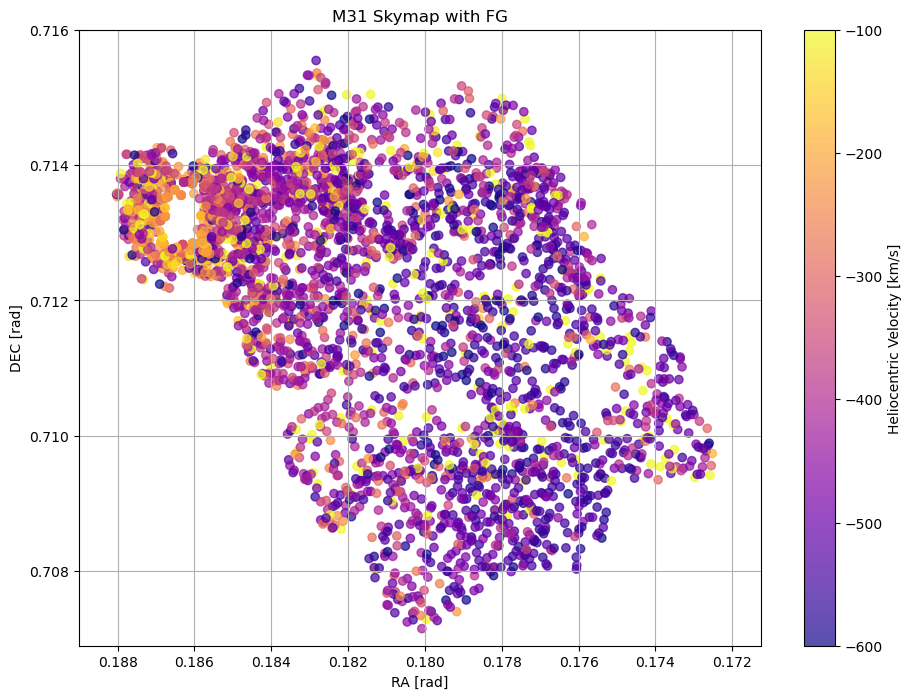

In [10]:
print(np.min(vhel))
print(np.max(vhel))
print(np.std(vhel))

plt.figure(figsize=(11,8))
#plt.axes(aspect='equal')
plt.scatter(ra_rad_fg, dec_rad_fg, alpha= 0.7, c=vhel_fg, cmap='plasma', vmin= -600, vmax=-100)
cbar = plt.colorbar()
cbar.set_label('Heliocentric Velocity [km/s]')
plt.grid()
plt.xlabel("RA [rad]")
plt.ylabel("DEC [rad]")
plt.title("M31 Skymap with FG")

plt.xlim(0.189, 0.17125)
plt.ylim(0.7069, 0.716)




(0.7069, 0.716)

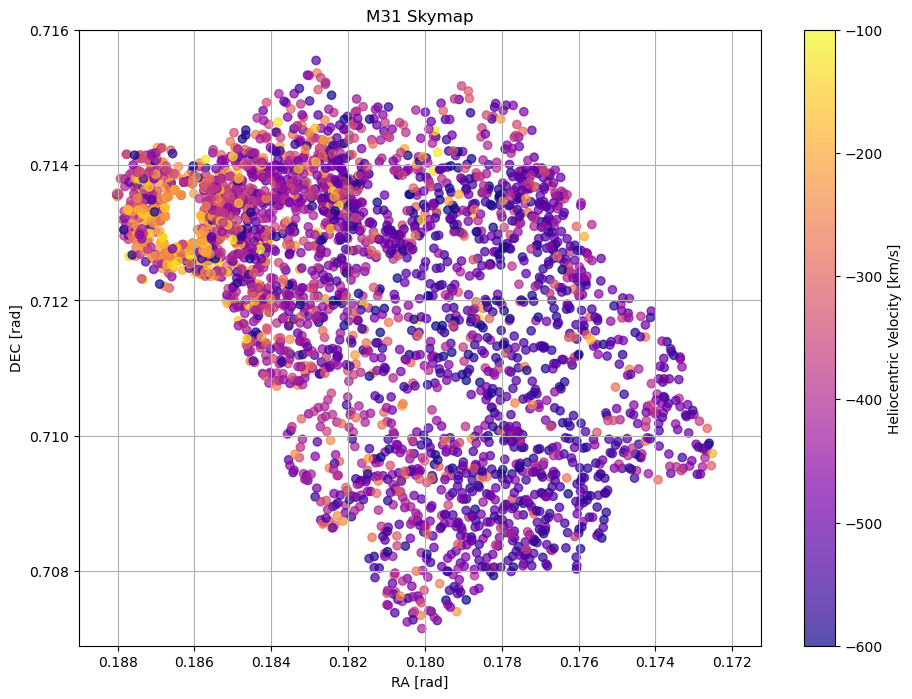

In [11]:

plt.figure(figsize=(11,8))
#plt.axes(aspect='equal')
plt.scatter(ra_rad, dec_rad, alpha= 0.7, c=vhel, cmap='plasma', vmin= -600, vmax=-100)
cbar = plt.colorbar()
cbar.set_label('Heliocentric Velocity [km/s]')
plt.grid()
plt.xlabel("RA [rad]")
plt.ylabel("DEC [rad]")
plt.title("M31 Skymap")

plt.xlim(0.189, 0.17125)
plt.ylim(0.7069, 0.716)

In [12]:
def get_dispersion(index, radius, std=False):
    ra_code = ra_rad[index]
    dec_code = dec_rad[index]
    vel_code = vhel[index]
    verr_code = vhel_err[index]

    v_dis = []
    ra_dis = []
    dec_dis = []
    for i in range(len(ra_code)):
        Xc = ra_code[i]
        Yc = dec_code[i]
        r = (np.sin(Yc) * np.sin(dec_code) + np.cos(Yc) * np.cos(dec_code) * np.cos(np.abs(Xc - ra_code)))#distance of all points to (x and y)
        ang = np.arccos(r)
        
        in_circle = np.where(ang < radius)[0]
        if len(in_circle) > 15:
            weights = 1/(verr_code[in_circle])
                
            xbar = np.average(vel_code[in_circle], weights = weights)

            numerator = np.sum(weights*(vel_code[in_circle] - xbar)**2)
            denominator = (len(in_circle)-1)/len(in_circle)*np.sum(weights)
                
            dispersion = np.sqrt(numerator/denominator)
            #vhel [stars_in_circle] the velocity of stars in my circle.
            v_dis.append(dispersion)
            ra_dis.append(Xc)
            dec_dis.append(Yc)
            
            
    return np.asarray(ra_dis), np.asarray(dec_dis), np.asarray(v_dis)

In [13]:

all_stars = list(range(0, len(ra_rad)))

print(len(all_stars))

ra_all, dec_all, vel_disp_all = get_dispersion(all_stars, 200*4.84814e-6)

print(len(ra_all))



3068


C:\Users\dougl\AppData\Local\Temp\ipykernel_11760\3406406678.py:14: RuntimeWarning: invalid value encountered in arccos
  ang = np.arccos(r)


3068


In [14]:
star_dist = []

for i in range(len(ra_all)):
    
    centerX = M31_rarad_center
    centerY = M31_decrad_center
    
    #centerX = 0.18635
    #centerY = 0.7132
    
    delta_dist = (np.sin(centerY))*(np.sin(dec_all))+(np.cos(centerY))*(np.cos(dec_all))*(np.cos(np.abs(centerX-ra_all)))
    dist = np.arccos(delta_dist)
    
    star_dist.append(dist[i])
    #print(dist)

print(len(star_dist))
print("min:", np.min(star_dist))
print("max:", np.max(star_dist))

star_dist= np.asarray(star_dist)

print()
print(len(ra_all))


3068
min: 0.00548095
max: 0.015022231

3068


0.015022231
0.00548095


(0.00500388618092984, 0.015499295317567885)

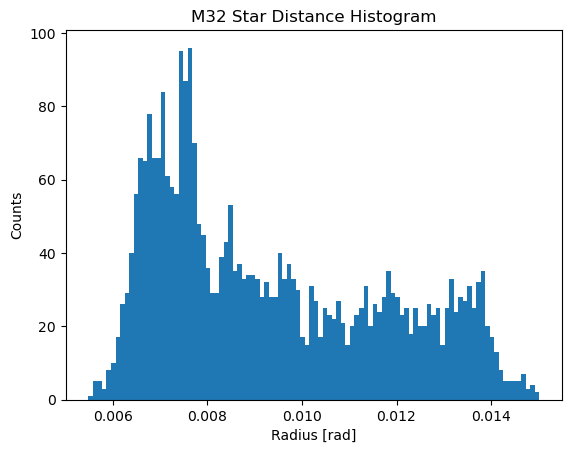

In [15]:
star_dist_hist = plt.hist(star_dist, bins=100)#, range=(0.006001,0.01399999))
plt.title('M32 Star Distance Histogram')
plt.xlabel("Radius [rad]")
plt.ylabel("Counts")

print(np.max(star_dist))
print(np.min(star_dist))
plt.xlim()

In [16]:
rings = np.zeros(40)
print(rings)

rings_distance = np.zeros(40)

#increment = 0.0002875
start = 0.0062
increment = 0.000345

#all_stars = list(range(0, len(ra_rad_M32)))

#ra_all, dec_all, vel_disp_all = get_dispersion(all_stars, 200*4.8481e-6)

ring0 = []
ring1 = []
ring2 = []
ring3 = []
ring4 = []
ring5 = []
ring6 = []
ring7 = []
ring8 = []
ring9 = []
ring10 = []
ring11 = []
ring12 = []
ring13 = []
ring14 = []
ring15 = []
ring16 = []
ring17 = []
ring18 = []
ring19 = []
ring20 = []
ring21 = []
ring22 = []
ring23 = []
ring24 = []
ring25 = []
ring26 = []
ring27 = []
ring28 = []
ring29 = []
ring30 = []
ring31 = []
ring32 = []
ring33 = []
ring34 = []
ring35 = []
ring36 = []
ring37 = []
ring38 = []
ring39 = []



def put_in_ring(index_number, ring_number, ring_name):
    if index_number == ring_number:
        ring_name.append(in_ring)


for x in range(40):
    in_ring = np.where((start+(increment*(x)) < star_dist) & (star_dist < start+(increment*(x+1))))[0]
    print(in_ring)
    
    #Number of rings and end point thing and increment stuff, it is like the end point added to the initial thing, which is why it is seen as extending so far out and has the nans for the last rings
    #should be changed
    
    rings[x] = np.nanmean(np.asarray(vel_disp_all)[in_ring])
    rings_distance[x] = (start+(increment*(x)) + (start+(increment*(x+1)))/2)
    #print(x)
    put_in_ring(x, 0, ring0)
    put_in_ring(x, 1, ring1)
    put_in_ring(x, 2, ring2)
    put_in_ring(x, 3, ring3)
    put_in_ring(x, 4, ring4)
    put_in_ring(x, 5, ring5)
    put_in_ring(x, 6, ring6)
    put_in_ring(x, 7, ring7)
    put_in_ring(x, 8, ring8)
    put_in_ring(x, 9, ring9)
    put_in_ring(x, 10, ring10)
    put_in_ring(x, 11, ring11)
    put_in_ring(x, 12, ring12)
    put_in_ring(x, 13, ring13)
    put_in_ring(x, 14, ring14)
    put_in_ring(x, 15, ring15)
    put_in_ring(x, 16, ring16)
    put_in_ring(x, 17, ring17)
    put_in_ring(x, 18, ring18)
    put_in_ring(x, 19, ring19)
    put_in_ring(x, 20, ring20)
    put_in_ring(x, 21, ring21)
    put_in_ring(x, 22, ring22)
    put_in_ring(x, 23, ring23)
    put_in_ring(x, 24, ring24)
    put_in_ring(x, 25, ring25)
    put_in_ring(x, 26, ring26)
    put_in_ring(x, 27, ring27)
    put_in_ring(x, 28, ring28)
    put_in_ring(x, 29, ring29)
    put_in_ring(x, 30, ring30)
    put_in_ring(x, 31, ring31)
    put_in_ring(x, 32, ring32)
    put_in_ring(x, 33, ring33)
    put_in_ring(x, 34, ring34)
    put_in_ring(x, 35, ring35)
    put_in_ring(x, 36, ring36)
    put_in_ring(x, 37, ring37)
    put_in_ring(x, 38, ring38)
    put_in_ring(x, 39, ring39)

#37 numbers

to_delete = [0]
rings = np.delete(rings, to_delete)
rings_distance = np.delete(rings_distance, to_delete)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[  17   18   19   87   89   90   97   98   99  100  101  102  104  105
  106  107  108  109  110  111  113  118  141  142  143  144  145  146
  148  151  186  240  242  248  249  252  254  255  257  260  262  263
  264  265  267  268  269  270  271  272  273  274  275  277  278  305
  313  314  340  373  377  384  386  387  388  390  391  392  394  395
  396  398  412  414  415  417  418  420  443  446  448  475  476  557
  560  561  562  563  567  568  569  641  642  694  696  713  777  778
  828  829  830  831  832  833  834  835  836  837  838  839  840  945
  946  976  977  978  979  980  981  982  983  984  985  986  999 1000
 1072 1112 1113 1114 1115 1116 1117 1118 1120 1252 1268 1269 1270 1271
 1272 1273 1274 1275 1286 1697 1698 1723 1727 1728 1730 1732 1755 1758
 1761]
[  14   15   16   62   64   65   66   67   70   71   72   73   74   75
   77   78   79   

C:\Users\dougl\AppData\Local\Temp\ipykernel_11760\3421986552.py:69: RuntimeWarning: Mean of empty slice
  rings[x] = np.nanmean(np.asarray(vel_disp_all)[in_ring])


In [17]:
rings

array([104.11297697, 105.73723776, 108.93242744, 112.38359812,
       104.2775951 ,  91.74261253,  86.54112143,  86.70160781,
        82.24404312,  78.26409736,  80.90450571,  77.93730367,
        69.55025389,  70.12014355,  70.87122872,  73.70915093,
        73.1489073 ,  74.44315265,  68.08737121,  68.23402047,
        67.39691139,  63.4651273 ,  58.71466725,  60.35135114,
        63.50612975,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan])

39
39
7.692555907652258
22.84104600938692


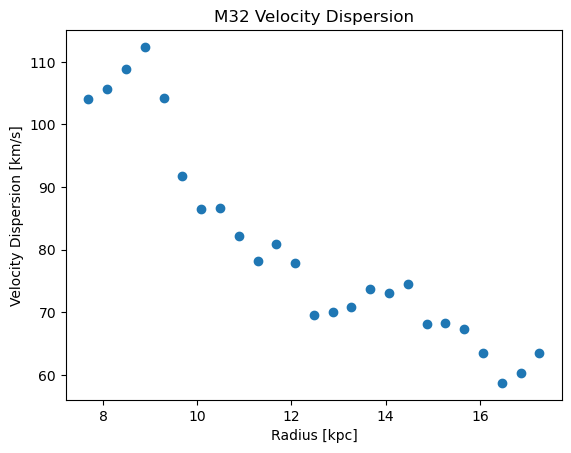

In [18]:
rings_distance_kpc = np.tan(rings_distance) * 770

print(len(rings_distance_kpc))

print(len(rings))

plt.scatter(rings_distance_kpc, rings)
plt.title("M32 Velocity Dispersion")
plt.xlabel("Radius [kpc]")
plt.ylabel("Velocity Dispersion [km/s]")


print(np.min(rings_distance_kpc))
print(np.max(rings_distance_kpc))

#plt.ylim(60, 150)

Text(0, 0.5, 'Counts')

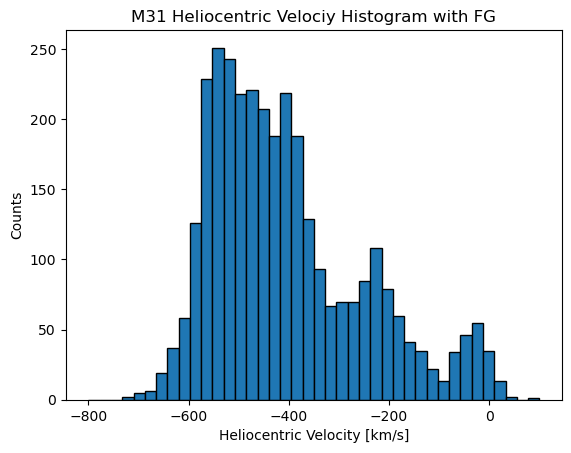

In [19]:
histogram = plt.hist(vhel_fg, bins=40, ec='k', range=(-800,100))
plt.title('M31 Heliocentric Velociy Histogram with FG')
plt.xlabel('Heliocentric Velocity [km/s]')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

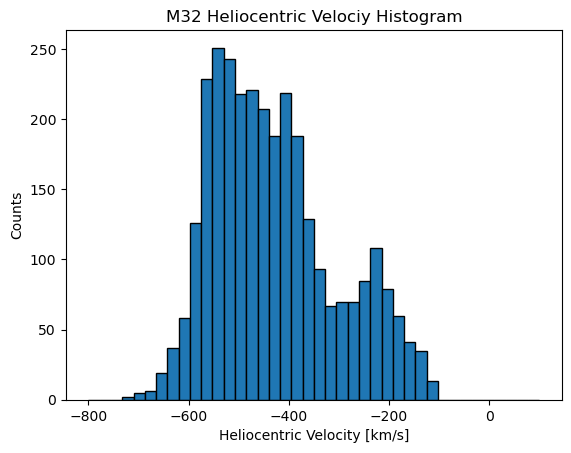

In [20]:
histogram = plt.hist(vhel, bins=40, ec='k', range=(-800,100))
plt.title('M32 Heliocentric Velociy Histogram')
plt.xlabel('Heliocentric Velocity [km/s]')
plt.ylabel('Counts')

In [21]:
print(histogram[0])
print(histogram[1])

[  0.   0.   0.   2.   5.   6.  19.  37.  58. 126. 229. 251. 243. 218.
 221. 207. 188. 219. 188. 129.  93.  67.  70.  70.  85. 108.  79.  60.
  41.  35.  13.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
[-800.  -777.5 -755.  -732.5 -710.  -687.5 -665.  -642.5 -620.  -597.5
 -575.  -552.5 -530.  -507.5 -485.  -462.5 -440.  -417.5 -395.  -372.5
 -350.  -327.5 -305.  -282.5 -260.  -237.5 -215.  -192.5 -170.  -147.5
 -125.  -102.5  -80.   -57.5  -35.   -12.5   10.    32.5   55.    77.5
  100. ]


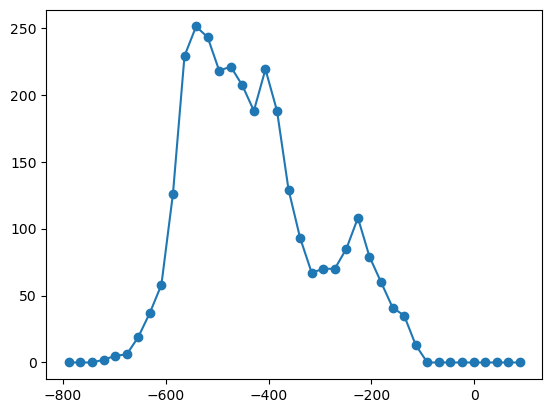

In [22]:
bins = histogram[1]
y_values = histogram[0]
x_values = np.asarray([0.5*(bins[i] + bins[i+1]) for i in range(len(bins)-1)])

plt.plot(x_values, y_values, '-o')

In [23]:

def gaussian(x, mu, sigma):
    return np.exp(-np.power(x-mu, 2.) / (2 * np.power(sigma, 2.)))


def f(x, mid1, dev1, amp1, mid2, dev2, amp2):#, mid3, dev3, amp3):
    #mid, deviation, amplitude
    gauss1 = gaussian(x, mid1, dev1)
    gauss2 = gaussian(x, mid2, dev2)
    #gauss3 = gaussian(x, mid3, dev3)
    
    return amp1*gauss1 + amp2*gauss2


In [24]:
from scipy.optimize import curve_fit

popt_vhel, pocv_vhel = curve_fit(f, xdata=x_values, ydata=y_values, p0=[-500, 100, 225, -190, 80, 60])#, -40, 40, 15])

print(popt_vhel)


[-477.46540771   94.56225226  249.83562095 -219.88280638   51.98731379
   85.80963876]


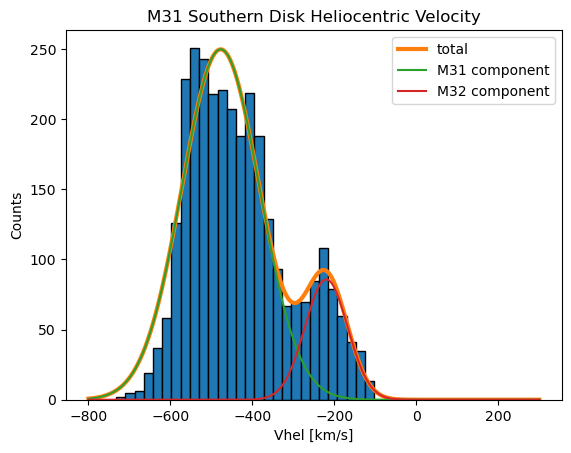

In [25]:
xtest = np.linspace(-800, 300, 2000)
ytest = f(xtest, popt_vhel[0], popt_vhel[1], popt_vhel[2], popt_vhel[3], popt_vhel[4], popt_vhel[5])#, popt_vhel[6], popt_vhel[7], popt_vhel[8])

gauss1 = popt_vhel[2]*gaussian(xtest, popt_vhel[0], popt_vhel[1])
gauss2 = popt_vhel[5]*gaussian(xtest, popt_vhel[3], popt_vhel[4])


histogram = plt.hist(vhel, bins=40, ec='k', range=(-800,100))

plt.plot(xtest, ytest, lw=3, label='total')
plt.plot(xtest, gauss1, label='M31 component')
plt.plot(xtest, gauss2, label='M32 component')

plt.xlabel('Vhel [km/s]')
plt.ylabel('Counts')
plt.title('M31 Southern Disk Heliocentric Velocity')
plt.legend()

[array([  17,   18,   19,   87,   89,   90,   97,   98,   99,  100,  101,
        102,  104,  105,  106,  107,  108,  109,  110,  111,  113,  118,
        141,  142,  143,  144,  145,  146,  148,  151,  186,  240,  242,
        248,  249,  252,  254,  255,  257,  260,  262,  263,  264,  265,
        267,  268,  269,  270,  271,  272,  273,  274,  275,  277,  278,
        305,  313,  314,  340,  373,  377,  384,  386,  387,  388,  390,
        391,  392,  394,  395,  396,  398,  412,  414,  415,  417,  418,
        420,  443,  446,  448,  475,  476,  557,  560,  561,  562,  563,
        567,  568,  569,  641,  642,  694,  696,  713,  777,  778,  828,
        829,  830,  831,  832,  833,  834,  835,  836,  837,  838,  839,
        840,  945,  946,  976,  977,  978,  979,  980,  981,  982,  983,
        984,  985,  986,  999, 1000, 1072, 1112, 1113, 1114, 1115, 1116,
       1117, 1118, 1120, 1252, 1268, 1269, 1270, 1271, 1272, 1273, 1274,
       1275, 1286, 1697, 1698, 1723, 1727, 1728, 1

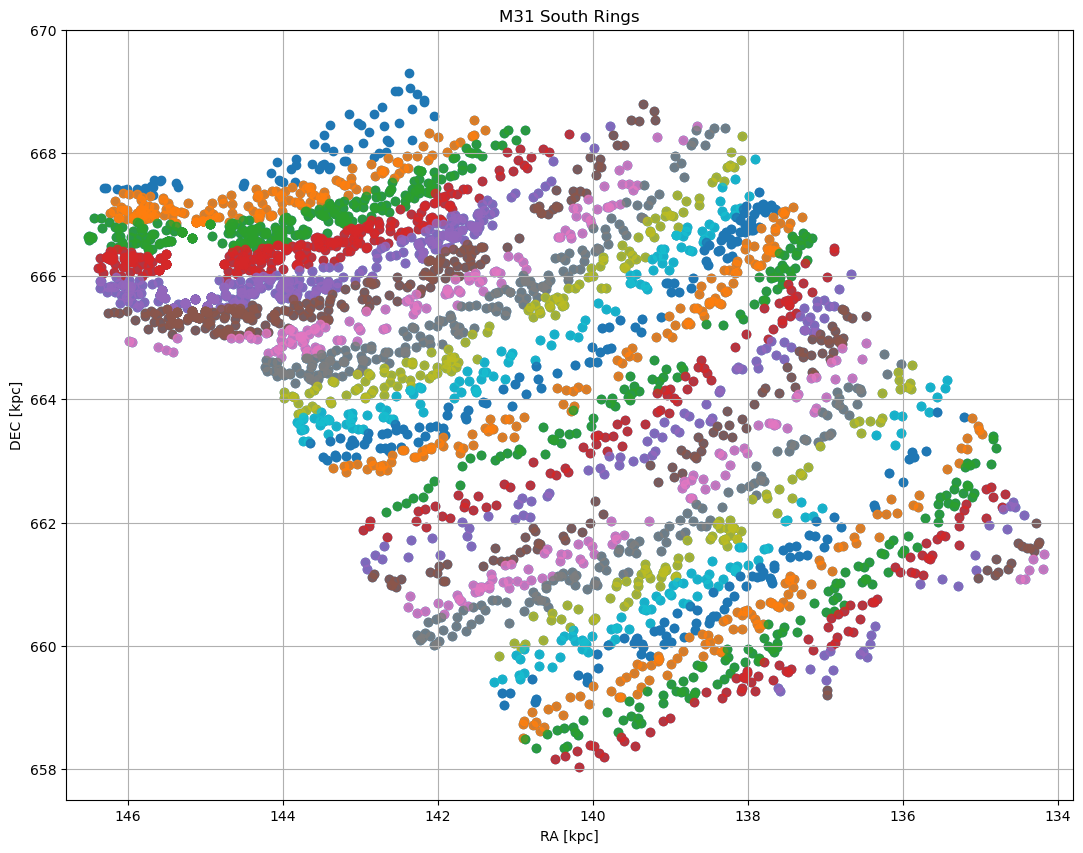

In [26]:
#converting ra and dec to kpc
ra_kpc = np.tan(ra_rad)*770
dec_kpc = np.tan(dec_rad)*770

plt.figure(figsize=(13,10))
#plt.axes(aspect='equal')
plt.scatter(ra_kpc, dec_kpc)#, c=vhel, cmap='plasma', vmin= -600, vmax=0)
plt.grid()
plt.xlabel("RA [kpc]")
plt.ylabel("DEC [kpc]")
plt.title("M31 South Rings")




plt.xlim(146.8, 133.8)


plt.ylim(657.5,670)
#plt.ylim(0.7069, 0.716)

plt.scatter(ra_kpc[ring0], dec_kpc[ring0], alpha=0.8)
plt.scatter(ra_kpc[ring1], dec_kpc[ring1], alpha=0.8)#c='red', )#, alpha= 0.7)#, c=vhel, cmap='plasma', vmin= -600, vmax=0)
plt.scatter(ra_kpc[ring2], dec_kpc[ring2], alpha=0.8)
plt.scatter(ra_kpc[ring3], dec_kpc[ring3], alpha=0.8)
plt.scatter(ra_kpc[ring4], dec_kpc[ring4], alpha=0.8)
plt.scatter(ra_kpc[ring5], dec_kpc[ring5], alpha=0.8)
plt.scatter(ra_kpc[ring6], dec_kpc[ring6], alpha=0.8)
plt.scatter(ra_kpc[ring7], dec_kpc[ring7], alpha=0.8)
plt.scatter(ra_kpc[ring8], dec_kpc[ring8], alpha=0.8)
plt.scatter(ra_kpc[ring9], dec_kpc[ring9], alpha=0.8)
plt.scatter(ra_kpc[ring10], dec_kpc[ring10], alpha=0.8)
plt.scatter(ra_kpc[ring11], dec_kpc[ring11], alpha=0.8)
plt.scatter(ra_kpc[ring12], dec_kpc[ring12], alpha=0.8)
plt.scatter(ra_kpc[ring13], dec_kpc[ring13], alpha=0.8)
plt.scatter(ra_kpc[ring14], dec_kpc[ring14], alpha=0.8)
plt.scatter(ra_kpc[ring15], dec_kpc[ring15], alpha=0.8)
plt.scatter(ra_kpc[ring16], dec_kpc[ring16], alpha=0.8)
plt.scatter(ra_kpc[ring17], dec_kpc[ring17], alpha=0.8)
plt.scatter(ra_kpc[ring18], dec_kpc[ring18], alpha=0.8)
plt.scatter(ra_kpc[ring19], dec_kpc[ring19], alpha=0.8)
plt.scatter(ra_kpc[ring20], dec_kpc[ring20], alpha=0.8)
plt.scatter(ra_kpc[ring21], dec_kpc[ring21], alpha=0.8)
plt.scatter(ra_kpc[ring22], dec_kpc[ring22], alpha=0.8)
plt.scatter(ra_kpc[ring23], dec_kpc[ring23], alpha=0.8)
plt.scatter(ra_kpc[ring24], dec_kpc[ring24], alpha=0.8)
plt.scatter(ra_kpc[ring25], dec_kpc[ring25], alpha=0.8)
plt.scatter(ra_kpc[ring26], dec_kpc[ring26], alpha=0.8)
plt.scatter(ra_kpc[ring27], dec_kpc[ring27], alpha=0.8)
plt.scatter(ra_kpc[ring28], dec_kpc[ring28], alpha=0.8)
plt.scatter(ra_kpc[ring29], dec_kpc[ring29], alpha=0.8)
plt.scatter(ra_kpc[ring30], dec_kpc[ring30], alpha=0.8)
plt.scatter(ra_kpc[ring31], dec_kpc[ring31], alpha=0.8)
plt.scatter(ra_kpc[ring32], dec_kpc[ring32], alpha=0.8)
plt.scatter(ra_kpc[ring33], dec_kpc[ring33], alpha=0.8)
plt.scatter(ra_kpc[ring34], dec_kpc[ring34], alpha=0.8)
plt.scatter(ra_kpc[ring35], dec_kpc[ring35], alpha=0.8)
plt.scatter(ra_kpc[ring36], dec_kpc[ring36], alpha=0.8)
plt.scatter(ra_kpc[ring37], dec_kpc[ring37], alpha=0.8)
#plt.scatter(ra_kpc[ring38], dec_kpc[ring38], alpha=0.8)
#plt.scatter(ra_kpc[ring39], dec_kpc[ring39], alpha=0.8)

#

print(ring0)
print(ring2)
print(ring3)
#plt.scatter(ra_kpc)



Text(24.847222222222214, 0.5, 'DEC [rad]')

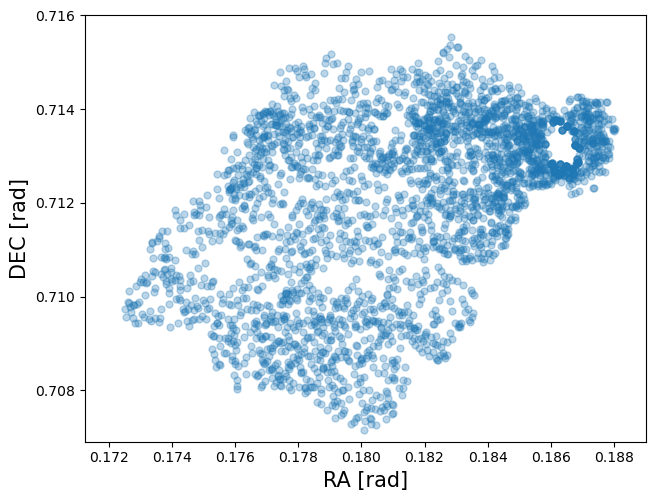

In [27]:
plt.plot(ra_rad, dec_rad, 'o', markersize=5, alpha=0.3)
plt.tight_layout()
plt.xlim(0.17125, 0.189)
plt.ylim(0.7069, 0.716)
plt.xlabel("RA [rad]", fontsize=15)
plt.ylabel("DEC [rad]", fontsize=15)

Text(0, 0.5, 'Velocity Dispersion [km/s]')

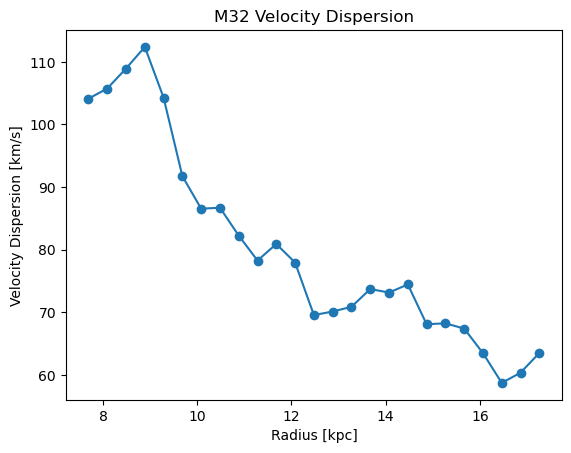

In [28]:
dispersion_x_values = rings_distance_kpc
dispersion_y_values = rings

plt.plot(dispersion_x_values, dispersion_y_values, '-o')
plt.title("M32 Velocity Dispersion")
plt.xlabel("Radius [kpc]")
plt.ylabel("Velocity Dispersion [km/s]")



In [29]:
rings_north = np.load("M31_North_Rings.npy")

rings_distance_kpc_north = np.load("M31_North_Rings_distance.npy")

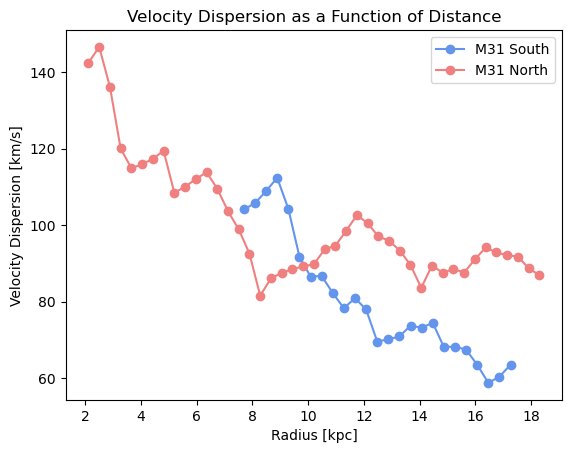

In [30]:
#combined
plt.plot(dispersion_x_values, dispersion_y_values, '-o', label="M31 South", c='cornflowerblue')
plt.plot(rings_distance_kpc_north, rings_north, '-o', c='lightcoral', label='M31 North')
plt.title("Velocity Dispersion as a Function of Distance")
plt.xlabel("Radius [kpc]")
plt.ylabel("Velocity Dispersion [km/s]")
plt.legend()


Text(0, 0.5, 'F814W [mag]')

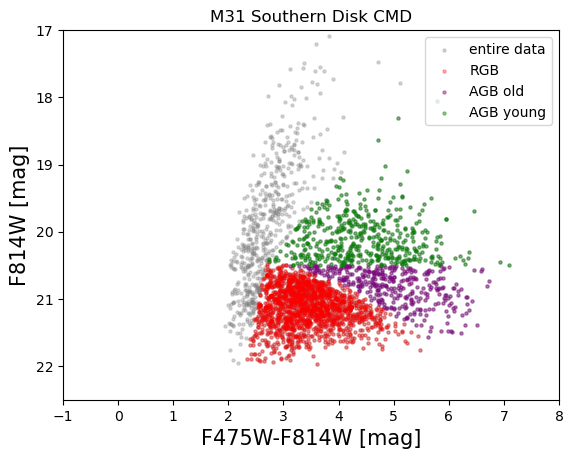

In [32]:

line = -2.6/0.7 * (f475w-f814w) + 30.42857142857143

a = 0.1
h = 2.1
k = 20.4
hyperbola = a*(f475w-f814w - h)**2. + k

#old MS selection: MS = np.where((f475w-f814w <=1) & (f475w -f814w >=-1))[0]

#MS = np.where(((f814w <=line) & (f475w -f814w >=-1)))[0]

line2 = (-2.5/0.7) * ((f475w-f814w)-2.307) + 21.2

#plt.plot(f475w-f814w, line2, c='purple')

#MS = np.where((f475w-f814w < 2.7) & (f814w<line2)
#)[0]

#f475w_MS = f475w[MS]
#f814w_MS = f814w[MS]

RGB = np.where((f814w > line) & (f814w > hyperbola))[0]

f475w_RGB = f475w[RGB]
f814w_RGB = f814w[RGB]

AGB_old = np.where((f814w < hyperbola) & (f814w > 20.5) & (f475w-f814w > 2.7))[0]

f475w_AGB_old = f475w[AGB_old]
f814w_AGB_old = f814w[AGB_old]

AGB_young = np.where((f814w < hyperbola) & (f814w > (-(f475w-f814w)+23.15)) & (f814w<20.5)& (f475w-f814w > 2.7))[0]

f475w_AGB_young = f475w[AGB_young]
f814w_AGB_young = f814w[AGB_young]


plt.scatter(f475w-f814w, f814w, s=5, alpha=0.3, c='gray', label='entire data')

#plt.scatter(f475w_MS-f814w_MS, f814w_MS, s=5, alpha=0.3, label='MS', c='blue')

plt.scatter(f475w_RGB-f814w_RGB, f814w_RGB, s=5, alpha=0.3, label='RGB', c='red')

plt.scatter(f475w_AGB_old-f814w_AGB_old, f814w_AGB_old, s=5, alpha=0.4, label='AGB old', c='purple')

plt.scatter(f475w_AGB_young-f814w_AGB_young, f814w_AGB_young, s=5, alpha=0.4, label='AGB young', c='green')

plt.legend(loc='upper right')
plt.title("M31 Northern Disk CMD divided into age bins", fontsize = 15)
plt.xlabel("f475w-f814w [mag]", fontsize=15)
plt.ylabel("f814w", fontsize=15)


plt.xlim(-1,8)
plt.ylim(22.5,17)
plt.title("M31 Southern Disk CMD")
plt.xlabel("F475W-F814W [mag]")
plt.ylabel("F814W [mag]")


In [33]:
len(ra_rad[AGB_young])

451

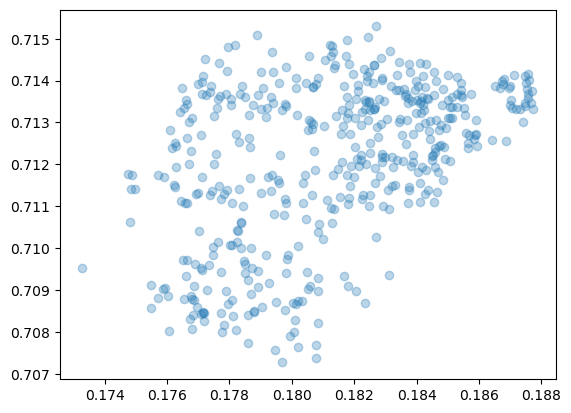

In [34]:
plt.scatter(ra_rad[AGB_young], dec_rad[AGB_young], alpha=0.3)

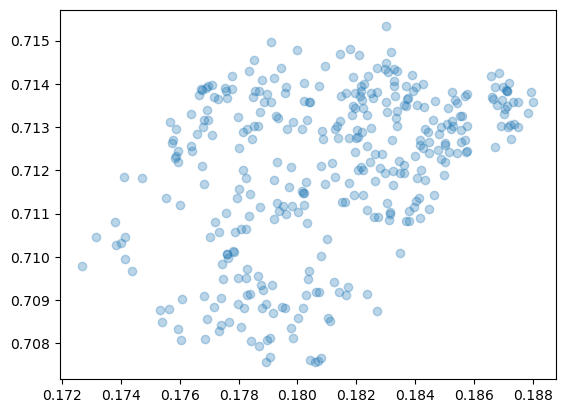

In [35]:
plt.scatter(ra_rad[AGB_old], dec_rad[AGB_old], alpha=0.3)

Text(0.5, 1.0, 'M31 Southern Disk RGB Heliocentric Velocity')

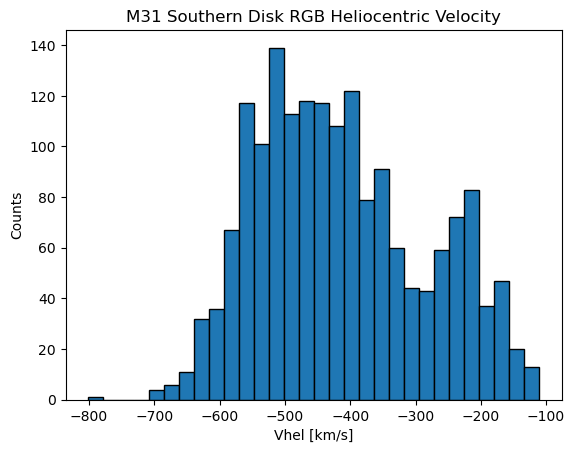

In [36]:
RGB_vhel = plt.hist(vhel[RGB], bins=30, ec='k')

plt.xlabel('Vhel [km/s]')
plt.ylabel('Counts')
plt.title('M31 Southern Disk RGB Heliocentric Velocity')

Text(0.5, 1.0, 'M31 Southern Disk Old AGB Heliocentric Velocity')

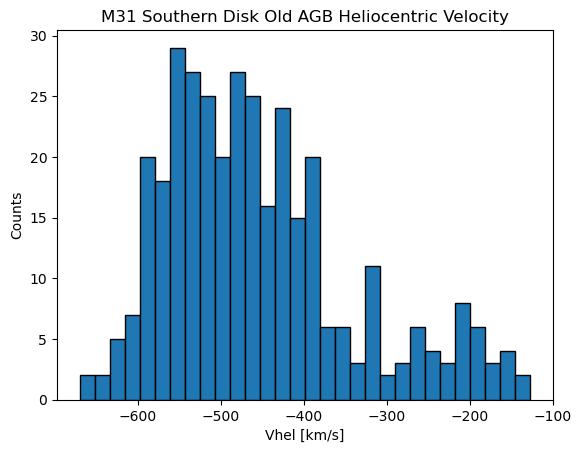

In [37]:
AGB_old_vhel = plt.hist(vhel[AGB_old], bins=30, ec='k')
plt.xlabel('Vhel [km/s]')
plt.ylabel('Counts')
plt.title('M31 Southern Disk Old AGB Heliocentric Velocity')

Text(0.5, 1.0, 'M31 Southern Disk Young AGB Heliocentric Velocity')

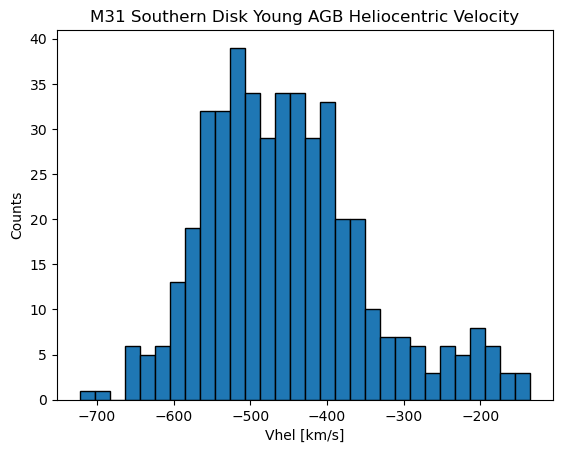

In [38]:
AGB_young_vhel = plt.hist(vhel[AGB_young], bins=30, ec='k')
plt.xlabel('Vhel [km/s]')
plt.ylabel('Counts')
plt.title('M31 Southern Disk Young AGB Heliocentric Velocity')

In [39]:
print(len(vel_disp_all))
print(len(vhel))

3068
3068


In [40]:
#star_dist_MS = star_dist[MS]

star_dist_RGB = star_dist[RGB]

star_dist_AGB_old = star_dist[AGB_old]

star_dist_AGB_young = star_dist[AGB_young]

In [41]:
print(np.max(star_dist_RGB))

rings_RGB = np.zeros(30)


rings_distance_RGB = np.zeros(30)

increment_RGB = 0.0004

#all_stars = list(range(0, len(ra_rad_M32)))

#ra_all, dec_all, vel_disp_all = get_dispersion(all_stars, 200*4.8481e-6)



for x in range(30):
    in_ring_RGB = np.where((increment_RGB*(x) < star_dist_RGB) & (star_dist_RGB < increment_RGB*(x+1)))[0]

    rings_RGB[x] = np.nanmean(np.asarray(vel_disp_all)[in_ring_RGB])
    rings_distance_RGB[x] = (increment_RGB*(x) + increment_RGB*(x+1))/2

0.015022231


C:\Users\dougl\AppData\Local\Temp\ipykernel_11760\1284610720.py:19: RuntimeWarning: Mean of empty slice
  rings_RGB[x] = np.nanmean(np.asarray(vel_disp_all)[in_ring_RGB])


30
30


Text(0, 0.5, 'Velocity Dispersion [km/s]')

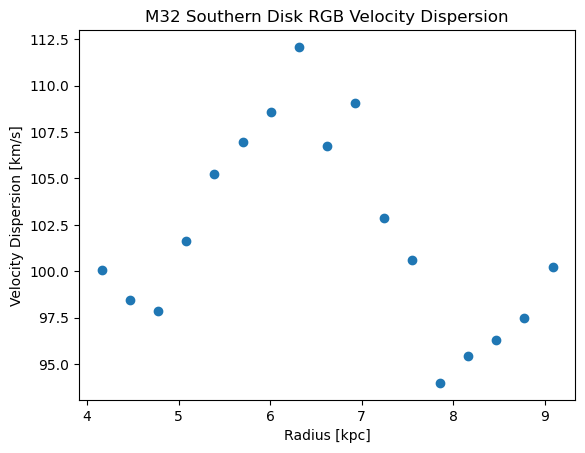

In [42]:
rings_distance_RGB_kpc = np.tan(rings_distance_RGB) * 770

print(len(rings_distance_RGB_kpc))
print(len(rings_RGB))

plt.scatter(rings_distance_RGB_kpc, rings_RGB)
plt.title("M32 Southern Disk RGB Velocity Dispersion")
plt.xlabel("Radius [kpc]")
plt.ylabel("Velocity Dispersion [km/s]")

In [43]:
print(np.max(star_dist_AGB_old))

rings_AGB_old = np.zeros(30)


rings_distance_AGB_old = np.zeros(30)

increment_AGB_old = 0.0004

#all_stars = list(range(0, len(ra_rad_M32)))

#ra_all, dec_all, vel_disp_all = get_dispersion(all_stars, 200*4.8481e-6)



for x in range(30):
    in_ring_AGB_old = np.where((increment_AGB_old*(x) < star_dist_AGB_old) & (star_dist_AGB_old < increment_AGB_old*(x+1)))[0]
    rings_AGB_old[x] = np.nanmean(np.asarray(vel_disp_all)[in_ring_AGB_old])
    rings_distance_AGB_old[x] = (increment_AGB_old*(x) + increment_AGB_old*(x+1))/2

0.014794332


C:\Users\dougl\AppData\Local\Temp\ipykernel_11760\3848317562.py:18: RuntimeWarning: Mean of empty slice
  rings_AGB_old[x] = np.nanmean(np.asarray(vel_disp_all)[in_ring_AGB_old])


30
30


Text(0, 0.5, 'Velocity Dispersion [km/s]')

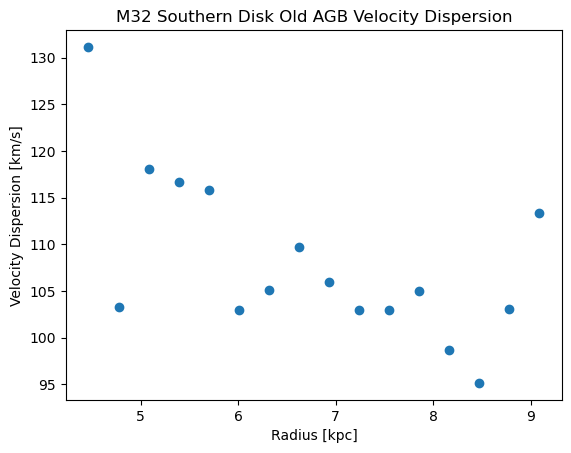

In [44]:
rings_distance_AGB_old_kpc = np.tan(rings_distance_AGB_old) * 770

print(len(rings_distance_AGB_old_kpc))
print(len(rings_AGB_old))

plt.scatter(rings_distance_AGB_old_kpc, rings_AGB_old)
plt.title("M32 Southern Disk Old AGB Velocity Dispersion")
plt.xlabel("Radius [kpc]")
plt.ylabel("Velocity Dispersion [km/s]")

In [45]:
print(np.max(star_dist_AGB_young))

rings_AGB_young = np.zeros(30)


rings_distance_AGB_young = np.zeros(30)

increment_AGB_young = 0.0004

#all_stars = list(range(0, len(ra_rad_M32)))

#ra_all, dec_all, vel_disp_all = get_dispersion(all_stars, 200*4.8481e-6)



for x in range(30):
    in_ring_AGB_young = np.where((increment_AGB_young*(x) < star_dist_AGB_young) & (star_dist_AGB_young < increment_AGB_young*(x+1)))[0]
    rings_AGB_young[x] = np.nanmean(np.asarray(vel_disp_all)[in_ring_AGB_young])
    rings_distance_AGB_young[x] = (increment_AGB_young*(x) + increment_AGB_young*(x+1))/2

0.0146689


C:\Users\dougl\AppData\Local\Temp\ipykernel_11760\202806764.py:18: RuntimeWarning: Mean of empty slice
  rings_AGB_young[x] = np.nanmean(np.asarray(vel_disp_all)[in_ring_AGB_young])


30
30


Text(0, 0.5, 'Velocity Dispersion [km/s]')

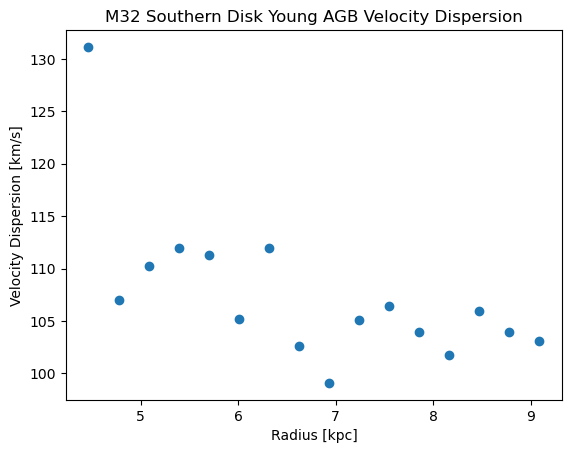

In [46]:
rings_distance_AGB_young_kpc = np.tan(rings_distance_AGB_young) * 770

print(len(rings_distance_AGB_young_kpc))
print(len(rings_AGB_young))

plt.scatter(rings_distance_AGB_young_kpc, rings_AGB_young)
plt.title("M32 Southern Disk Young AGB Velocity Dispersion")
plt.xlabel("Radius [kpc]")
plt.ylabel("Velocity Dispersion [km/s]")

In [47]:
#ra_kpc = np.tan(ra_rad)*770
#dec_kpc = np.tan(dec_rad)*770

-800.8169097900391
-110.34104824066162


(147.126009, 133.559247)

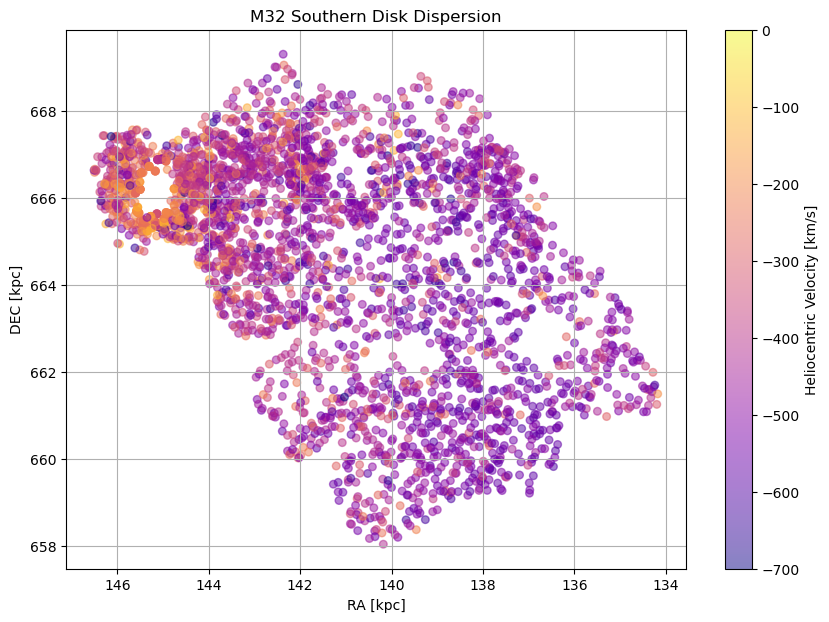

In [48]:
print(np.min(vhel))
print(np.max(vhel))

plt.figure(figsize=(10,7))
skymap = plt.scatter(ra_kpc, dec_kpc, s=30, c=vhel, cmap='plasma', alpha=0.5, vmin=-700, vmax=0)
cbar = plt.colorbar()
cbar.set_label('Heliocentric Velocity [km/s]')
plt.grid()
plt.xlabel("RA [kpc]")
plt.ylabel("DEC [kpc]")
plt.title("M32 Southern Disk Dispersion")

plt.ylim(657.470874, 669.8609)
plt.xlim(147.126009, 133.559247)

-800.8169097900391
-110.34104824066162


(147.126009, 133.559247)

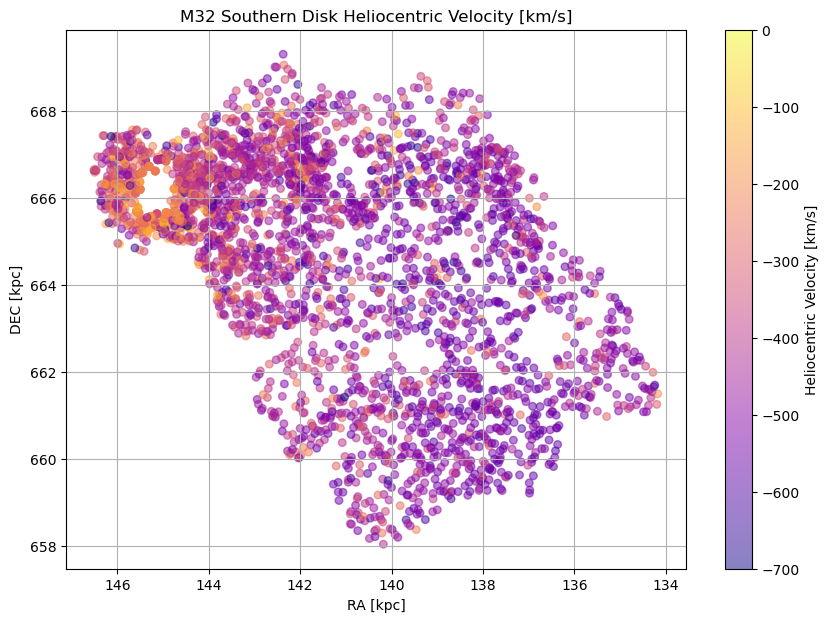

In [49]:
print(np.min(vhel))
print(np.max(vhel))

plt.figure(figsize=(10,7))
skymap = plt.scatter(ra_kpc, dec_kpc, s=30, c=vhel, cmap='plasma', alpha=0.5, vmin=-700, vmax=0)
cbar = plt.colorbar()
cbar.set_label('Heliocentric Velocity [km/s]')
plt.grid()
plt.xlabel("RA [kpc]")
plt.ylabel("DEC [kpc]")
plt.title("M32 Southern Disk Heliocentric Velocity [km/s]")
plt.ylim(657.470874, 669.8609)
plt.xlim(147.126009, 133.559247)

34.075039689586866
137.22099455319372


(147.126009, 133.559247)

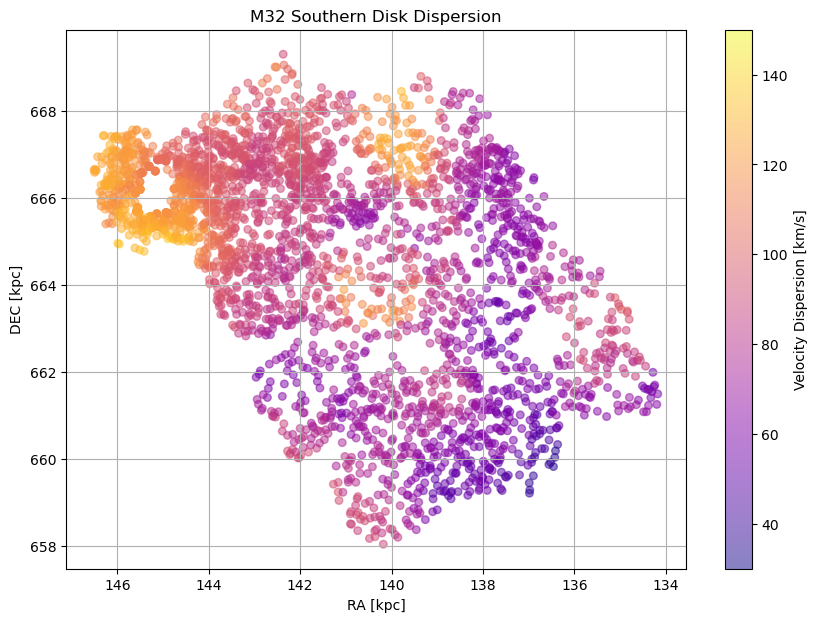

In [50]:
print(np.min(vel_disp_all))
print(np.max(vel_disp_all))

plt.figure(figsize=(10,7))
skymap = plt.scatter(ra_kpc, dec_kpc, s=30, c=vel_disp_all, cmap='plasma', alpha=0.5, vmin=30, vmax=150)
cbar = plt.colorbar()
cbar.set_label('Velocity Dispersion [km/s]')
plt.grid()
plt.xlabel("RA [kpc]")
plt.ylabel("DEC [kpc]")
plt.title("M32 Southern Disk Dispersion")

plt.ylim(657.470874, 669.8609)
plt.xlim(147.126009, 133.559247)


In [52]:
ra_kpc_south = ra_kpc
dec_kpc_south = dec_kpc
vel_disp_all_south = vel_disp_all


In [53]:
#ra_MS, dec_MS, vel_disp_MS = get_dispersion(MS, 200*4.8481e-6)

ra_RGB, dec_RGB, vel_disp_RGB = get_dispersion(RGB, 200*4.84814e-6)

ra_AGB_old, dec_AGB_old, vel_disp_AGB_old = get_dispersion(AGB_old, 275*4.84814e-6)

ra_AGB_young, dec_AGB_young, vel_disp_AGB_young = get_dispersion(AGB_young, 275*4.84814e-6)

C:\Users\dougl\AppData\Local\Temp\ipykernel_11760\3406406678.py:14: RuntimeWarning: invalid value encountered in arccos
  ang = np.arccos(r)


148.78539157861553
60.509328640480625


(147.126009, 133.559247)

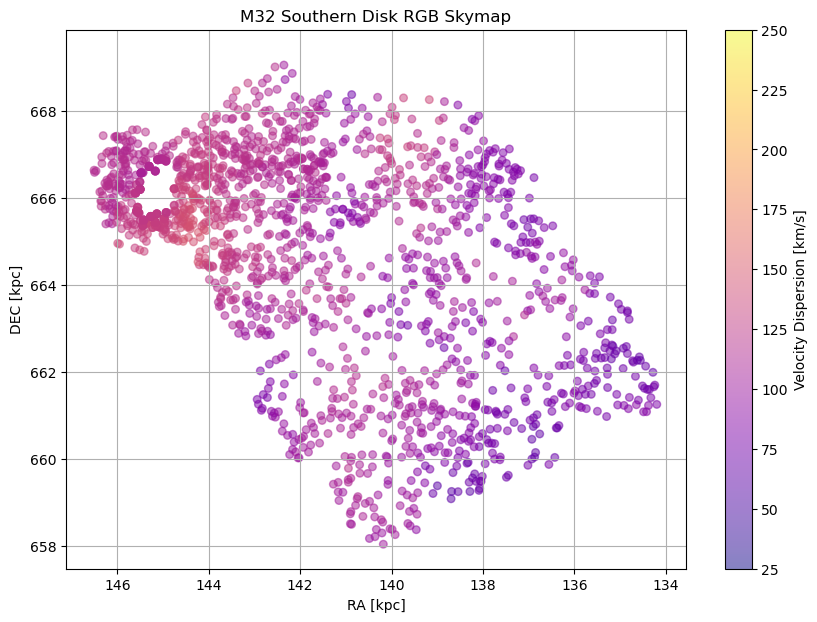

In [54]:
print(np.max(vel_disp_RGB))
print(np.min(vel_disp_RGB))


ra_kpc_RGB = np.tan(ra_RGB)*770
dec_kpc_RGB = np.tan(dec_RGB)*770

plt.figure(figsize=(10,7))
plt.scatter(ra_kpc_RGB, dec_kpc_RGB, s=30, c=vel_disp_RGB, cmap='plasma', alpha=0.5, vmin=25, vmax=250)
cbar = plt.colorbar()
cbar.set_label('Velocity Dispersion [km/s]')
plt.grid()
plt.xlabel("RA [kpc]")
plt.ylabel("DEC [kpc]")
plt.title("M32 Southern Disk RGB Skymap")

plt.ylim(657.470874, 669.8609)
plt.xlim(147.126009, 133.559247)


146.33825802692527
41.531153116800944


(147.126009, 133.559247)

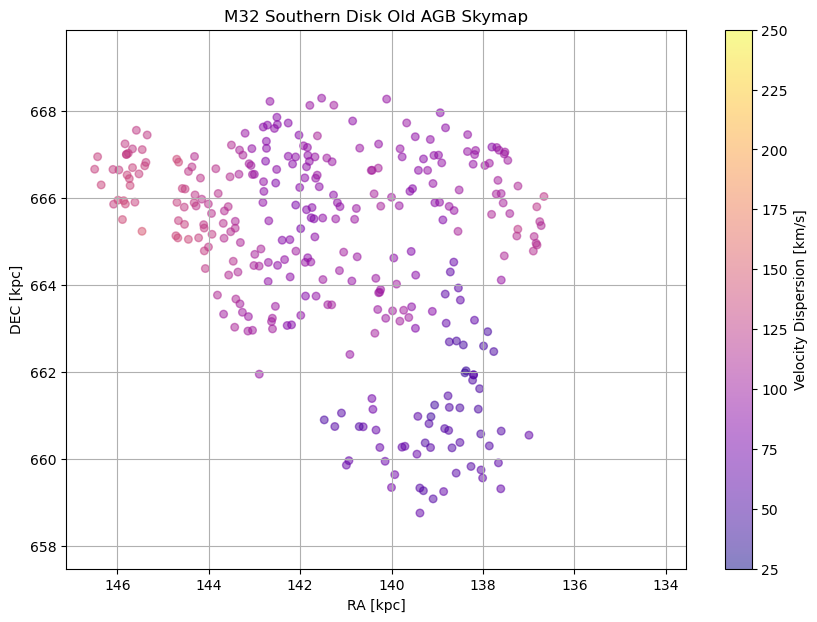

In [55]:
print(np.max(vel_disp_AGB_old))
print(np.min(vel_disp_AGB_old))

ra_kpc_AGB_old = np.tan(ra_AGB_old)*770
dec_kpc_AGB_old = np.tan(dec_AGB_old)*770

plt.figure(figsize=(10,7))
plt.scatter(ra_kpc_AGB_old, dec_kpc_AGB_old, s=30, c=vel_disp_AGB_old, cmap='plasma', alpha=0.5, vmin=25, vmax=250)
cbar = plt.colorbar()
cbar.set_label('Velocity Dispersion [km/s]')
plt.grid()
plt.xlabel("RA [kpc]")
plt.ylabel("DEC [kpc]")
plt.title("M32 Southern Disk Old AGB Skymap")

plt.ylim(657.470874, 669.8609)
plt.xlim(147.126009, 133.559247)


150.82499781982753
40.69012984139134


(147.126009, 133.559247)

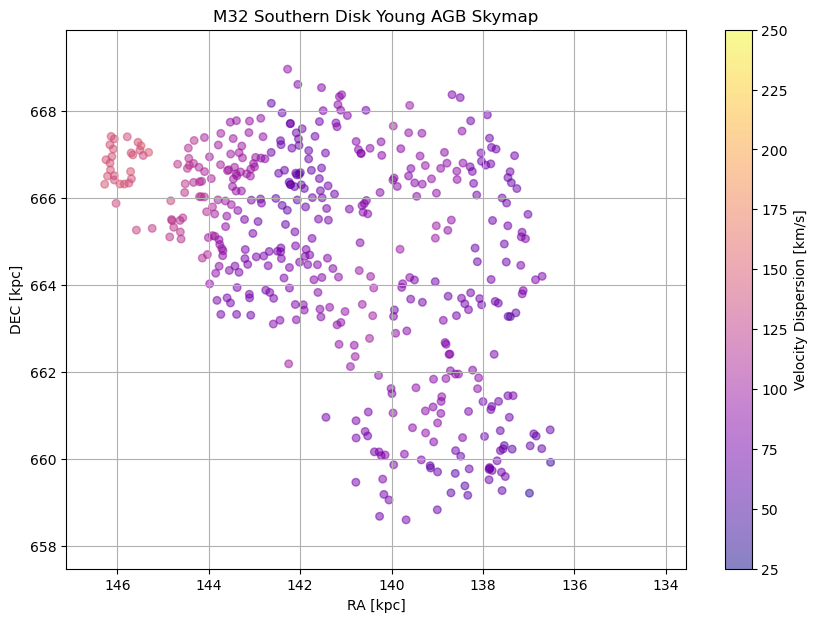

In [56]:
print(np.max(vel_disp_AGB_young))
print(np.min(vel_disp_AGB_young))

ra_kpc_AGB_young = np.tan(ra_AGB_young)*770
dec_kpc_AGB_young = np.tan(dec_AGB_young)*770

plt.figure(figsize=(10,7))
plt.scatter(ra_kpc_AGB_young, dec_kpc_AGB_young, s=30, c=vel_disp_AGB_young, cmap='plasma', alpha=0.5, vmin=25, vmax=250)
cbar = plt.colorbar()
cbar.set_label('Velocity Dispersion [km/s]')
plt.grid()
plt.xlabel("RA [kpc]")
plt.ylabel("DEC [kpc]")
plt.title("M32 Southern Disk Young AGB Skymap")

plt.ylim(657.470874, 669.8609)
plt.xlim(147.126009, 133.559247)


Text(0.5, 1.0, 'Age Group Velocity Dispersion Histogram')

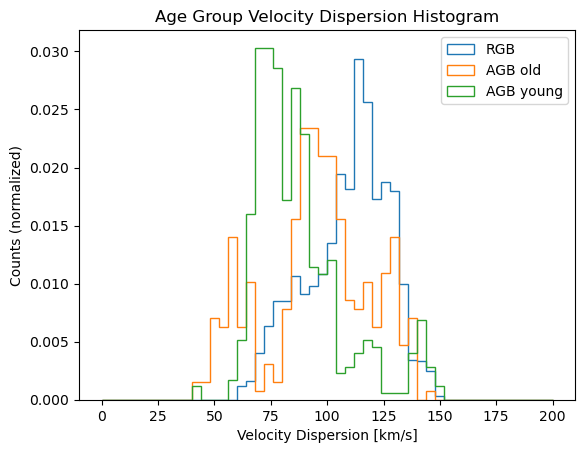

In [57]:
#plt.hist(vel_disp_MS, bins=50, histtype='step', density='true', range=(0,200), label='MS')
plt.hist(vel_disp_RGB, bins=50, histtype='step', density='true', range=(0,200), label='RGB')
plt.hist(vel_disp_AGB_old, bins=50, histtype='step', density='true', range=(0,200), label='AGB old')
plt.hist(vel_disp_AGB_young, bins=50, histtype='step', density='true', range=(0,200), label='AGB young')
plt.legend(loc='upper right')
plt.xlabel("Velocity Dispersion [km/s]")
plt.ylabel("Counts (normalized)")
plt.title("Age Group Velocity Dispersion Histogram")

87.09180021590225
95.68892812878848
109.13247571691552


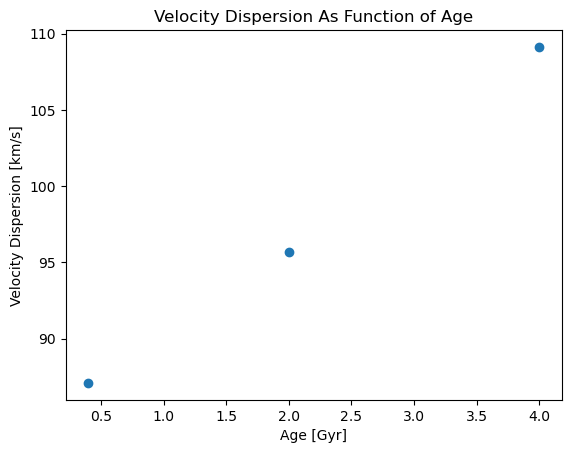

In [58]:
arr = [np.mean(vel_disp_RGB), np.mean(vel_disp_AGB_old), np.mean(vel_disp_AGB_young)]
ages = [4, 2, 0.4]

plt.scatter(ages, arr)
plt.xlabel("Age [Gyr]")
plt.ylabel("Velocity Dispersion [km/s]")
plt.title("Velocity Dispersion As Function of Age")

print(np.mean(vel_disp_AGB_young))
print(np.mean(vel_disp_AGB_old))
print(np.mean(vel_disp_RGB))

#plt.xlim(-0.5, 7)
#plt.ylim(0, 120)

[0.03 4.   2.   0.4 ]


Text(0.5, 1.0, 'Velocity Dispersion As Function of Age')

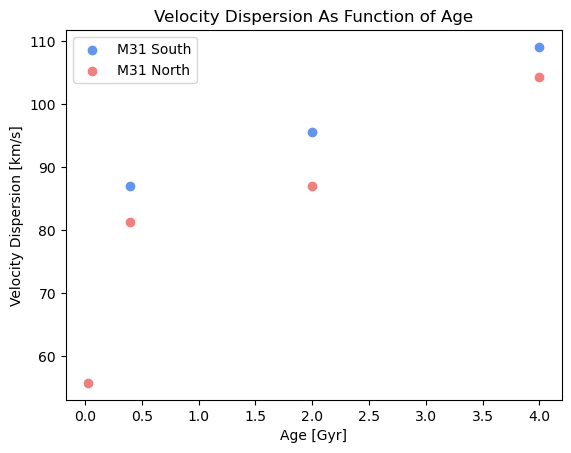

In [59]:
#combined
north_arr = np.load("M31_north_arr.npy")
north_ages = np.load("M31_north_ages.npy")

print(north_ages)
plt.scatter(ages, arr, c='cornflowerblue', label='M31 South')
plt.scatter(north_ages, north_arr, c='lightcoral', label='M31 North')


plt.xlabel("Age [Gyr]")
plt.ylabel("Velocity Dispersion [km/s]")
plt.legend()
plt.title("Velocity Dispersion As Function of Age")




In [68]:
#try to combine north and south data so dispersion isn't affected
#maybe: try to do rings for whole data set, see if dispersion as function of distance is affected


print(len(ra_all))
print(len(ra_north))
print(len(ra_comb))
print()
print(len(vhel))
print(len(vhel_north))
print(len(vhel_comb))

In [72]:
def derek_AAAAA(index, radius, std=False):
    ra_code = ra_comb[index]
    dec_code = dec_comb[index]
    vel_code = vhel_comb[index]
    verr_code = vhel_err_comb[index]

    v_dis = []
    ra_dis = []
    dec_dis = []
    for i in range(len(ra_code)):
        Xc = ra_code[i]
        Yc = dec_code[i]
        r = (np.sin(Yc) * np.sin(dec_code) + np.cos(Yc) * np.cos(dec_code) * np.cos(np.abs(Xc - ra_code)))#distance of all points to (x and y)
        ang = np.arccos(r)
        
        in_circle = np.where(ang < radius)[0]
        if len(in_circle) > 15:
            weights = 1/(verr_code[in_circle])
                
            xbar = np.average(vel_code[in_circle], weights = weights)

            numerator = np.sum(weights*(vel_code[in_circle] - xbar)**2)
            denominator = (len(in_circle)-1)/len(in_circle)*np.sum(weights)
                
            dispersion = np.sqrt(numerator/denominator)
            print(dispersion)
            #vhel [stars_in_circle] the velocity of stars in my circle.
            v_dis.append(dispersion)
            ra_dis.append(Xc)
            dec_dis.append(Yc)
            
            
    return np.asarray(ra_dis), np.asarray(dec_dis), np.asarray(v_dis)